# Creating artificial clustered trajectories

## TODO

- [x] Allow for along-track scale variability (can be used to, e.g., keep start or end points fixed).
- [ ] Use clustering algorithm for diagnosing clusters again.
  - [x] Use Euclidian metric (as all trajectories have the same length)
  - [ ] Use other metric (as all trajectories have the same length)
- [ ] Find out how to best use (known) centroids for distance-based or similarity-based classification.

## Imports

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

In [2]:
np.random.seed(123)

## Functions to build trajectories

Here's a few functions that we can use to create and morph trajectories.

In [3]:
def create_smooth_traj(number_steps=100, smooth_length=11):
    window = np.hanning(smooth_length)
    window /= window.sum()
    
    return pd.DataFrame({
        "x": np.convolve(
            np.random.normal(size=(number_steps + smooth_length - 1, )),
            window,
            mode="valid",
        ).cumsum(),
        "y": np.convolve(
            np.random.normal(size=(number_steps + smooth_length - 1, )),
            window,
            mode="valid",
        ).cumsum(),
    })

In [4]:
def create_traj_from_to(
    start_x=0, 
    start_y=0, 
    end_x=1, 
    end_y=1, 
    number_steps=100,
):
    return pd.DataFrame({
        "x": np.linspace(start_x, end_x, number_steps),
        "y": np.linspace(start_y, end_y, number_steps),
    })

## Functions to morph in trajectory-attached coordinate system

In [5]:
def get_local_coord_system(traj):
    
    # forward and backward (incoming diff)
    fwd = - traj.diff(periods=-1).add_prefix("d")
    bwd = traj.diff(periods=1).add_prefix("d")

    # symmetric direction
    # Note how we don't normalise before addition. Hence, larger steps have
    # a stronger influence on the symmetric direction of the trajectory.
    symm = fwd.add(bwd, axis=1) # / 2
    symm = symm.where(~symm.isnull(), fwd.fillna(0).add(bwd.fillna(0), axis=0))

    # normalize along-track directions
    symm = symm.div(symm.apply(lambda row: sum(row ** 2) ** 0.5, axis=1), axis=0)

    # rename
    symm = symm.rename(columns={"dx": "e1x", "dy": "e1y"})

    # add cross-track vector
    symm["e2x"] = symm["e1y"]
    symm["e2y"] = - symm["e1x"]

    return symm

In [6]:
def modify_trajectory(traj=None, along_shifts=None, across_shifts=None):
    directions = get_local_coord_system(traj) 
    mod_along = directions.filter(like="e1").mul(along_shifts, axis=0)
    mod_across = directions.filter(like="e2").mul(across_shifts, axis=0)
    mod_total = mod_along + mod_across.to_numpy()
    return traj + mod_total.to_numpy()

In [7]:
def get_shifts(length=None, scale=1):
    return pd.Series(
        data=np.random.normal(0, scale, size=(length, ))
    )

In [8]:
def get_smooth_shifts(traj=None, scale=1, smooth_length=1):
    window = np.hanning(smooth_length)
    window /= window.sum()
    shifts = get_shifts(length=len(traj) + smooth_length - 1, scale=scale)
    return pd.Series(
        data=np.convolve(
            shifts,
            window,
            mode="valid"
        )
    )

In [9]:
def create_sine_weight(length=None, wave_number=0.5):
    return pd.Series(np.sin(np.linspace(0, 2 * np.pi * wave_number, length)))

In [10]:
def create_logistic_weight(length=None, growth_rate=0.5):
    return pd.Series(
        1 / (1 + np.exp(- growth_rate * (np.arange(length) - length // 2)))
    )

In [11]:
def create_linear_weight(length=None, ):
    return pd.Series(
        np.linspace(0, 1, length)
    )

## Here's what's happening

In [12]:
traj = create_smooth_traj(number_steps=7, smooth_length=6)

In [13]:
directions = get_local_coord_system(traj)
directions

,e1x,e1y,e2x,e2y
0,-0.483439,0.875378,0.875378,0.483439
1,-0.244289,0.969703,0.969703,0.244289
2,-0.177920,0.984045,0.984045,0.177920
3,-0.397971,0.917398,0.917398,0.397971
4,-0.426636,0.904423,0.904423,0.426636
5,-0.108018,0.994149,0.994149,0.108018
6,-0.011864,0.999930,0.999930,0.011864


In [14]:
along_shifts = get_smooth_shifts(traj=traj, scale=1, smooth_length=7)
across_shifts = get_smooth_shifts(traj=traj, scale=1, smooth_length=7)

In [15]:
shifts = pd.DataFrame({
    "along": along_shifts,
    "across": across_shifts,
})

In [16]:
traj_morphed = modify_trajectory(
    traj=traj, 
    along_shifts=along_shifts,
    across_shifts=across_shifts
)

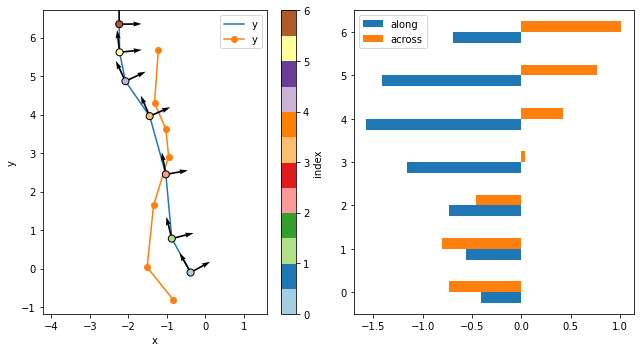

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(9, 5))

traj.plot.line(x="x", y="y", ax=ax[0])
traj.reset_index().plot.scatter(
    x="x", y="y", marker="o",
    s=50, c="index", cmap="Paired",
    edgecolor="k",
    zorder=100,
    ax=ax[0],
);
ax[0].quiver(traj["x"], traj["y"], directions["e1x"], directions["e1y"], scale=10, zorder=99)
ax[0].quiver(traj["x"], traj["y"], directions["e2x"], directions["e2y"], scale=10, zorder=99)

traj_morphed.plot.line(
    x="x", y="y", marker="o",
    ax=ax[0]
);
ax[0].axis('equal');

shifts.plot.barh(ax=ax[1])

fig.tight_layout();

## Now create clusters of trajectories

In [18]:
number_clusters = 8
number_members = 50
traj_lengths = 100

In [19]:
centroids = {
    n: create_smooth_traj(number_steps=traj_lengths, smooth_length=41)
    for n in range(number_clusters)
}

In [20]:
clusters = pd.concat({
    n: pd.concat({
        m: modify_trajectory(
            traj=c, 
            along_shifts=(
                create_linear_weight(length=len(c))
                * get_smooth_shifts(traj=c, smooth_length=31, scale=2)
            ),
            across_shifts=(
                create_linear_weight(length=len(c))
                * get_smooth_shifts(traj=c, smooth_length=31, scale=4)
            ),
        )
        for m in range(number_members)
    }, axis=0)
    for n, c in centroids.items()
}, axis=0)

# there's probably a better way for this:
clusters.index = clusters.index.set_names(["cluster", "member", "step"])

In [21]:
clusters

x         y
cluster member step                     
0       0      0     -0.029879 -0.009245
               1     -0.093524 -0.030601
               2     -0.183109 -0.068963
               3     -0.293645 -0.129011
               4     -0.419270 -0.214872
...                        ...       ...
7       49     95    12.231205 -1.245803
               96    12.438749 -0.954998
               97    12.648505 -0.656360
               98    12.859518 -0.347830
               99    13.069286 -0.027588

[40000 rows x 2 columns]

In [22]:
centroids = pd.concat(centroids, axis=0)
centroids.index = centroids.index.set_names(["cluster", "step"])

In [23]:
centroids

x         y
cluster step                     
0       0     -0.029879 -0.009245
        1     -0.089299 -0.032166
        2     -0.173788 -0.073425
        3     -0.278810 -0.137124
        4     -0.399193 -0.226894
...                 ...       ...
7       95    12.036740 -0.743244
        96    12.326173 -0.516949
        97    12.614303 -0.293051
        98    12.900788 -0.070313
        99    13.185219  0.152590

[800 rows x 2 columns]

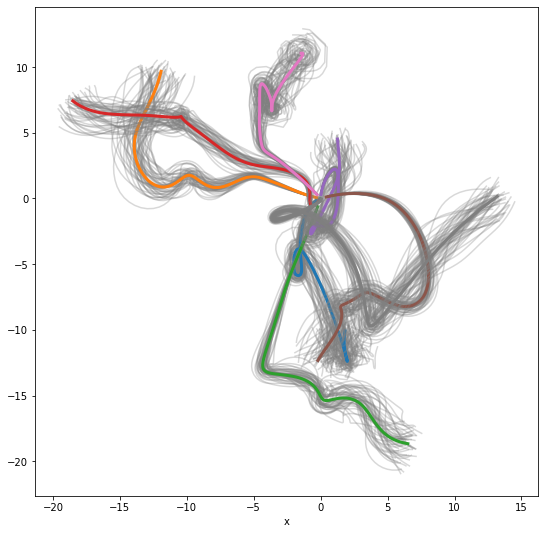

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(9, 9))

for c in centroids.index.get_level_values("cluster").unique():
    for m in clusters.loc[c].index.get_level_values("member").unique():
        clusters.loc[c].loc[m].plot.line(
            x="x", y="y", color="gray", alpha=0.3, ax=ax, legend=False, label=None
        )
    centroids.loc[c].plot.line(
        x="x", y="y", ax=ax, linewidth=3, label=f"cluster {c}", legend=None
    )

## Clustering

In [25]:
# %pip install sklearn

### Euclidian metric

With all trajectories having the same size, we can just use a Euclidian metric between _all_ the elements.

We'll use `DBSCAN` and `KMeans` which are both available with scikit-learn.

Note that for both clustering alorithms, we need hyper-parameters wich usually cannot be chosen easily:

- For `DBSCAN`, we need to set the minimal cluster size (`min_samples`) and the max distance between cluster members to be considered close to each other (`eps`). For large datasets and when looking for prominent pathways, a small `min_samples` (default is 5?) usually is sufficient. `eps`, howerver, depends on the number of points in the trajectories.  It may be difficult to find an `eps` that can handle multiple spatial scales (thinking of convoluted compact vs. long-reaching trajectories).

- For `KMeans`, we need to pick a number of clusters. Choosing too few or too many will lead to unclear separation between clusters.

The advantage of `DBSCAN` is we don't need to know the number of clusters beforehand.

For very large datasets, however, where we might want to use only a representative subset of the trajectories for identifying clusters and then classifying all other trajectories according to those clusters, we cannot use `DBSCAN` directly, as it does not know _centroids_.

In [26]:
from sklearn.cluster import DBSCAN, KMeans

In [27]:
dbs = DBSCAN(eps=5, min_samples=5)

In [28]:
kms = KMeans(n_clusters=8)

We need an explicit trajectory id (which we construct from the cluster id and the member id).

In [29]:
clusters["id"] = pd.DataFrame(clusters.reset_index().apply(
    lambda row: tuple((row["cluster"], row["member"])),
    axis=1
)).set_index(clusters.index)

Then, we reshape the dataframe so that each row represents a full trajectory:

In [30]:
trajs = clusters.reset_index().set_index(["id", "step"])[["x", "y"]].unstack(level=1)

In [31]:
trajs.head()

x                                                    \
step              0         1         2         3         4         5    
id                                                                       
(0.0, 0.0) -0.029879 -0.093524 -0.183109 -0.293645 -0.419270 -0.553057   
(0.0, 1.0) -0.029879 -0.096927 -0.192167 -0.311337 -0.449140 -0.598701   
(0.0, 2.0) -0.029879 -0.092725 -0.179609 -0.284890 -0.402742 -0.526900   
(0.0, 3.0) -0.029879 -0.098498 -0.193960 -0.312461 -0.449407 -0.598934   
(0.0, 4.0) -0.029879 -0.090722 -0.176469 -0.281900 -0.401381 -0.528806   

                                                    ...          y             \
step              6         7         8         9   ...         90         91   
id                                                  ...                         
(0.0, 0.0) -0.688009 -0.817878 -0.938758 -1.048285  ... -11.754034 -11.543857   
(0.0, 1.0) -0.753001 -0.905736 -1.052220 -1.189788  ... -12.674471 -12.469944   
(0.0, 2.0) -0.651334 -0.770569 -0.880679 -0.979898  ... -12.503859 -12.293979   
(0.0, 3.0) -0.754144 -0.907900 -1.054232 -1.188846  ... -11.829398 -11.652609   
(0.0, 4.0) -0.658179 -0.784305 -0.904065 -1.015695  ... -11.742708 -11.592763   

                                                                              \
step               92         93         94         95         96         97   
id                                                                             
(0.0, 0.0) -11.314470 -11.077296 -10.844859 -10.631995 -10.453952 -10.320489   
(0.0, 1.0) -12.249436 -12.016352 -11.772172 -11.522627 -11.274623 -11.038197   
(0.0, 2.0) -12.058805 -11.807809 -11.550873 -11.294258 -11.045303 -10.812947   
(0.0, 3.0) -11.453275 -11.240038 -11.022437 -10.808128 -10.605072 -10.421222   
(0.0, 4.0) -11.420845 -11.229969 -11.018767 -10.788027 -10.548014 -10.308874   

                                  
step               98         99  
id                                
(0.0, 0.0) -10.232464 -10.176643  
(0.0, 1.0) -10.828127 -10.667590  
(0.0, 2.0) -10.602452 -10.410655  
(0.0, 3.0) -10.260563 -10.118335  
(0.0, 4.0) -10.087572  -9.934218  

[5 rows x 200 columns]

Now, let `DBSCAN` find all clusters and label all trajectories:

In [32]:
dbs_id = pd.Series(
    data=dbs.fit_predict(trajs),
    index=trajs.index
)

And do the same with `KMeans`:

In [33]:
kms_id = pd.Series(
    data=kms.fit_predict(trajs),
    index=trajs.index
)

Reshape the trajectory data to use a step index again and add the cluster ids found by `DBSCAN` and `KMeans`:

In [34]:
trajs = trajs.stack()

In [35]:
trajs = trajs.join(dbs_id.rename("dbs_id")).reset_index().set_index(["id", "step"])
trajs = trajs.join(kms_id.rename("kms_id")).reset_index().set_index(["id", "step"])

Have a look: With `DBSCAN`, we'll find many trajectories that could not be assigned a cluster id. `KMeans`, will classify all trajectories.

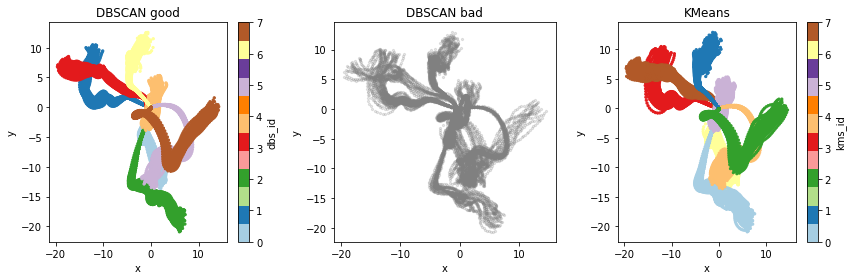

In [36]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

trajs.where(trajs.dbs_id >= 0).reset_index().plot.scatter(
    x="x", y="y", c="dbs_id",
    s=5, cmap="Paired",
    ax=ax[0],
    vmin=0, vmax=number_clusters-1,
)
ax[0].set_title("DBSCAN good")

trajs.where(trajs.dbs_id < 0).reset_index().plot.scatter(
    x="x", y="y", c="gray",
    s=5, alpha=0.2,
    ax=ax[1],
)
ax[1].set_title("DBSCAN bad")

trajs.reset_index().plot.scatter(
    x="x", y="y", c="kms_id",
    s=5, cmap="Paired",
    ax=ax[2],
    vmin=0, vmax=number_clusters-1,
)
ax[2].set_title("KMeans")

fig.tight_layout();